In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

# Set up

## Get data

In [2]:
h5file = "/Users/22252335/Documents/DustMassDensity/data/all_data.h5"

In [3]:
with h5py.File(h5file, "r") as f:
    print("Top-level groups or datasets:")
    for key in f.keys():
        print(key)
with h5py.File(h5file, "r") as f:
    zmids = np.array( f["zmids"][:] )  
    zbins = np.array( f["zbins"][:] )  
    lbtmids = np.array( f["lbtmids"][:] )  
    lbtbins = np.array( f["lbtbins"][:] )  
    LSSCorrection = np.array( f["LSSCorrection"][:] )   

len(zmids)

Top-level groups or datasets:
DaleMagphys
LSSCorrection
Md_corr
Omega
Photometry
cosmic
fit
lbtbins
lbtmids
vmax
zbins
zmids


16

## Plot stuff

In [4]:
def get_n_colors(n, cmap_name="viridis"):
    cmap = plt.get_cmap(cmap_name)  # Get colormap
    return [cmap(i / (n - 1)) for i in range(n)]  # Sample n colors

def MidFactor(n):
    # Create a list to store divisors
    divisors = []
    # Iterate from 1 to n and check divisibility
    for i in range(1, n + 1):
        if n % i == 0:
            # If 'i' divides 'n' evenly, it's a divisor
            divisors.append(i)
            
    return divisors[len(divisors)//2]
            
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as path_effects

plt.rcParams['font.size']= 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.direction'] = "in"

plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7

plt.rcParams["xtick.minor.size"] = plt.rcParams["xtick.major.size"]/2.0
plt.rcParams["ytick.minor.size"] = plt.rcParams["ytick.major.size"]/2.0

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

plt.rcParams['xtick.major.pad'] = 7

plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams["text.usetex"] = True

# Vmax plots

In [5]:
dmf = []
for i in range(len(zmids)):
    dmf.append(pd.read_hdf(h5file, "vmax/Mdust/zb" + str(i+1)))

dmf_fit = []
for i in range(len(zmids)):
    dmf_fit.append(pd.read_hdf(h5file, "fit/Mdust/zb" + str(i+1)))

smf = []
for i in range(len(zmids)):
    smf.append(pd.read_hdf(h5file, "vmax/Mstar/zb" + str(i+1)))

smf_fit = []
for i in range(len(zmids)):
    smf_fit.append(pd.read_hdf(h5file, "fit/Mstar/zb" + str(i+1)))

In [6]:
dunne11 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/dmf/dunne11.csv")
pozzi20 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/dmf/pozzi20.csv")
beeston24 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/dmf/beeston24.csv")

## DMF

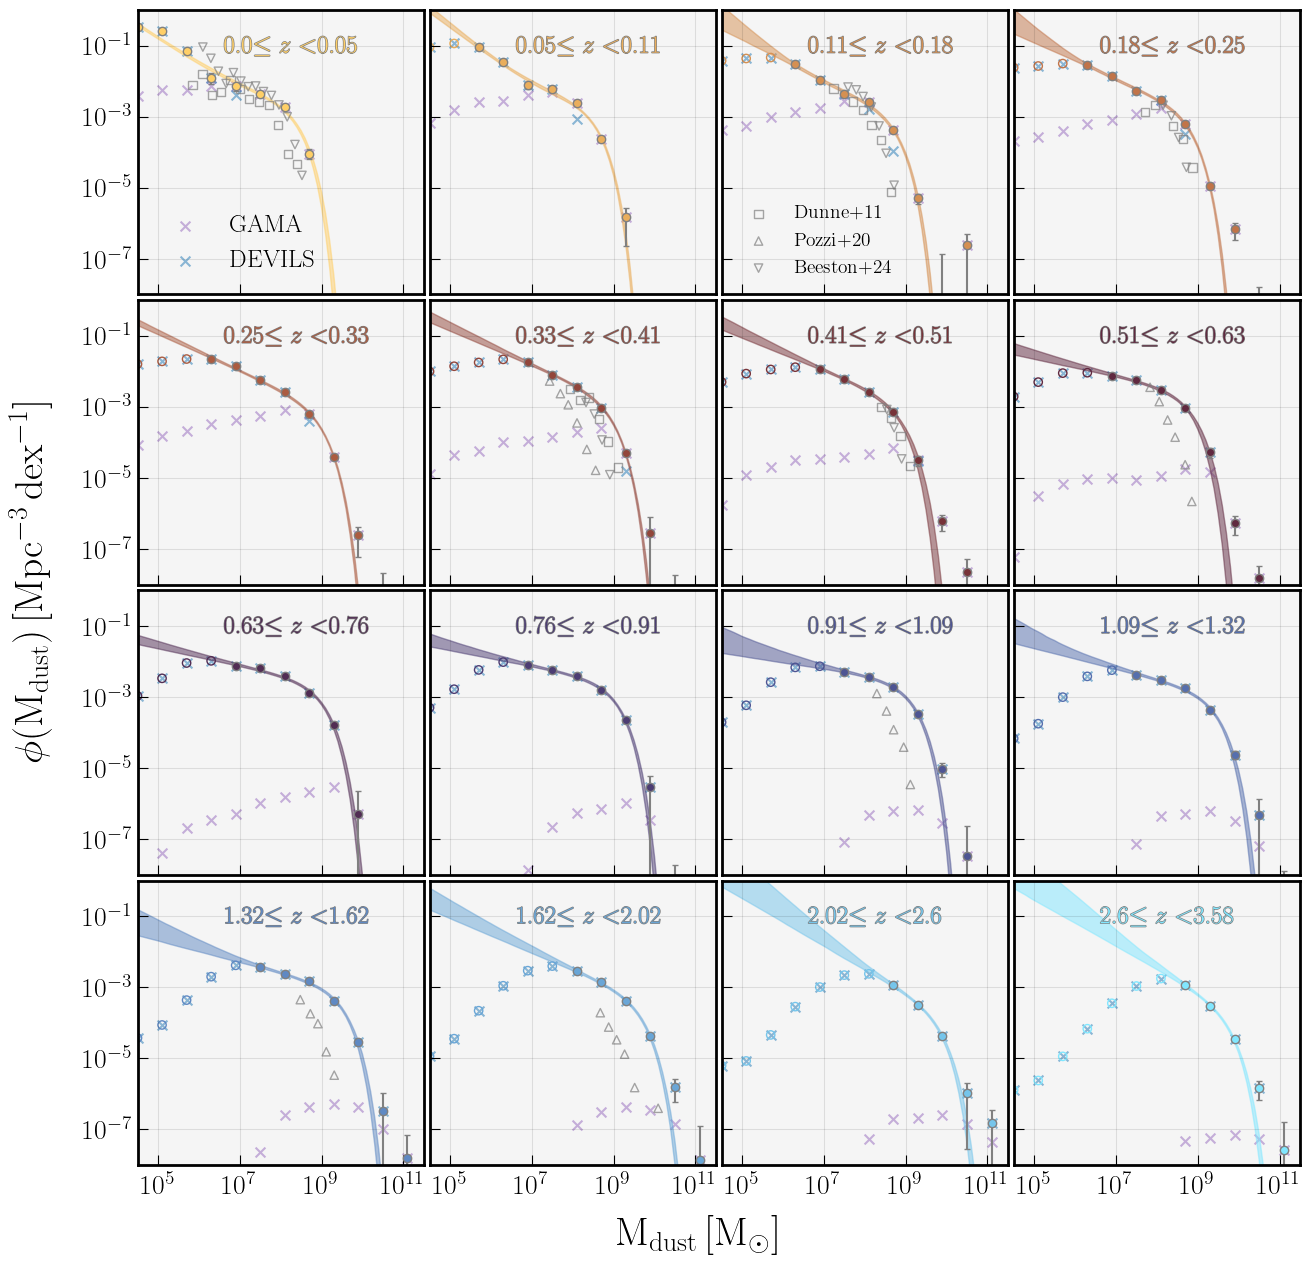

In [7]:
colours = get_n_colors(len(zmids), "managua")

fig, ax = plt.subplots(max([MidFactor(len(zmids)), len(zmids)/MidFactor(len(zmids))]), 
                       min([MidFactor(len(zmids)), len(zmids)/MidFactor(len(zmids))]), 
                       figsize = (15,15), constrained_layout = False, sharex=True, sharey=True)

handles = []
count = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):

        gama_handles = ax[i,j].scatter(
            10**dmf[count]["x"],
            dmf[count]["GAMA"],
            color = "tab:purple",
            marker = "x", 
            alpha = 0.5,
            s = 50,
            label = "GAMA"
        )
        devils_handles = ax[i,j].scatter(
            10**dmf[count]["x"],
            dmf[count]["DEVILS"],
            color = "tab:blue",
            marker = "x",
            alpha = 0.5,
            s = 50,
            label = "DEVILS"
        )
        if count == 0:
            handles.append(gama_handles)
            handles.append(devils_handles)
            
        ax[i,j].errorbar(
            10**dmf[count]["x"][dmf[count]["mlim"] == 1.0],
            dmf[count]["vmax"][dmf[count]["mlim"] == 1.0],
            yerr = dmf[count]["vmaxErr"][dmf[count]["mlim"] == 1.0], 
            fmt = "o",
            capsize = 2,
            markerfacecolor = colours[count],
            ecolor = "grey",
            markeredgecolor = "grey",
            alpha = 1.0
        )
        ax[i,j].scatter(
            10**dmf[count]["x"][dmf[count]["mlim"] == 0.0],
            dmf[count]["vmax"][dmf[count]["mlim"] == 0.0],
            facecolor = "none",
            edgecolor = colours[count]
        )
        ax[i,j].fill_between(
            x = dmf_fit[count]["x"],
            y1 = dmf_fit[count]["Q16"],
            y2 = dmf_fit[count]["Q84"],
            color = colours[count],
            alpha = 0.5
        )

        ax[i,j].text(
            0.3, 0.85, f"{round(zbins[count],2)}" + "$ \\leq z <$" f"{round(zbins[count+1],2)}", 
            transform = ax[i,j].transAxes, 
            fontsize = 18, 
            color = colours[count], 
            path_effects = [path_effects.Stroke(linewidth=1, foreground='grey'),path_effects.Normal()]
        )

        ## literature observations
        if count == 0: #z=0.02
            ax[i,j].scatter(
                dunne11[dunne11["z"]==0.05]["Mdust"],
                dunne11[dunne11["z"]==0.05]["phi"],
                marker = "s", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            ax[i,j].scatter(
                beeston24[beeston24["z"]==0.05]["X"],
                beeston24[beeston24["z"]==0.05]["Y"],
                marker = "v", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 2: #z = 0.15
            pozzi20h = ax[i,j].scatter(
                pozzi20[pozzi20["z"]==0.15]["Mdust"],
                pozzi20[pozzi20["z"]==0.15]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7, 
                label = "Pozzi+20"
            )
            dunne11h = ax[i,j].scatter(
                dunne11[dunne11["z"]==0.15]["Mdust"],
                dunne11[dunne11["z"]==0.15]["phi"],
                marker = "s", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7, 
                label = "Dunne+11"
            )
            beeston24h = ax[i,j].scatter(
                beeston24[beeston24["z"]==0.15]["X"],
                beeston24[beeston24["z"]==0.15]["Y"],
                marker = "v", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7, 
                label = "Beeston+24"
            )
        if count == 3: ## z=0.22
            ax[i,j].scatter(
                dunne11[dunne11["z"]==0.25]["Mdust"],
                dunne11[dunne11["z"]==0.25]["phi"],
                marker = "s", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            ax[i,j].scatter(
                beeston24[beeston24["z"]==0.25]["X"],
                beeston24[beeston24["z"]==0.25]["Y"],
                marker = "v", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 5: ## z=0.38
            ax[i,j].scatter(
                pozzi20[pozzi20["z"]==0.325]["Mdust"],
                pozzi20[pozzi20["z"]==0.325]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            ax[i,j].scatter(
                dunne11[dunne11["z"]==0.35]["Mdust"],
                dunne11[dunne11["z"]==0.35]["phi"],
                marker = "s", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            ax[i,j].scatter(
                beeston24[beeston24["z"]==0.35]["X"],
                beeston24[beeston24["z"]==0.35]["Y"],
                marker = "v", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 6: ## z=0.48
            ax[i,j].scatter(
                dunne11[dunne11["z"]==0.45]["Mdust"],
                dunne11[dunne11["z"]==0.45]["phi"],
                marker = "s", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            ax[i,j].scatter(
                beeston24[beeston24["z"]==0.45]["X"],
                beeston24[beeston24["z"]==0.45]["Y"],
                marker = "v", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 7:
            ax[i,j].scatter(
                pozzi20[pozzi20["z"]==0.6]["Mdust"],
                pozzi20[pozzi20["z"]==0.6]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 10:
            ax[i,j].scatter(
                pozzi20[pozzi20["z"]==1.0]["Mdust"],
                pozzi20[pozzi20["z"]==1.0]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 12:
            ax[i,j].scatter(
                pozzi20[pozzi20["z"]==1.5]["Mdust"],
                pozzi20[pozzi20["z"]==1.5]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
        if count == 13:
            ax[i,j].scatter(
                pozzi20[pozzi20["z"]==2.15]["Mdust"],
                pozzi20[pozzi20["z"]==2.15]["phi"],
                marker = "^", 
                facecolor = "none", 
                edgecolor = "grey",
                alpha = 0.7
            )
            
        ax[i,j].set_facecolor('whitesmoke')  
        ax[i,j].grid(color = "black", alpha = 0.1)
     
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        
        ax[i,j].set_xlim([10**4.5, 10**11.5])
        ax[i,j].set_ylim([1e-8, 1.0])

        ax[i,j].set_xticks([10**5.0, 10**7.0, 10**9.0, 10**11.0])
        ax[i,j].set_yticks([10**-7, 10**-5, 10**-3, 10**-1])

        count += 1
        
ax[0,0].legend(handles = handles, loc = "lower left", frameon = False, fontsize = 18)
ax[0,2].legend(handles = [dunne11h, pozzi20h, beeston24h], loc = "lower left", frameon = False, fontsize = 14)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.supxlabel(r"$\mathrm{M_{dust} \, [M_{\odot}]}$", y = 0.05)
fig.supylabel(r"$\mathrm{\phi(M_{dust}) \, [Mpc^{-3} \, dex^{-1}]}$", x = 0.04)
fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/dmf.pdf", dpi = 240, bbox_inches='tight')

## DMF evol

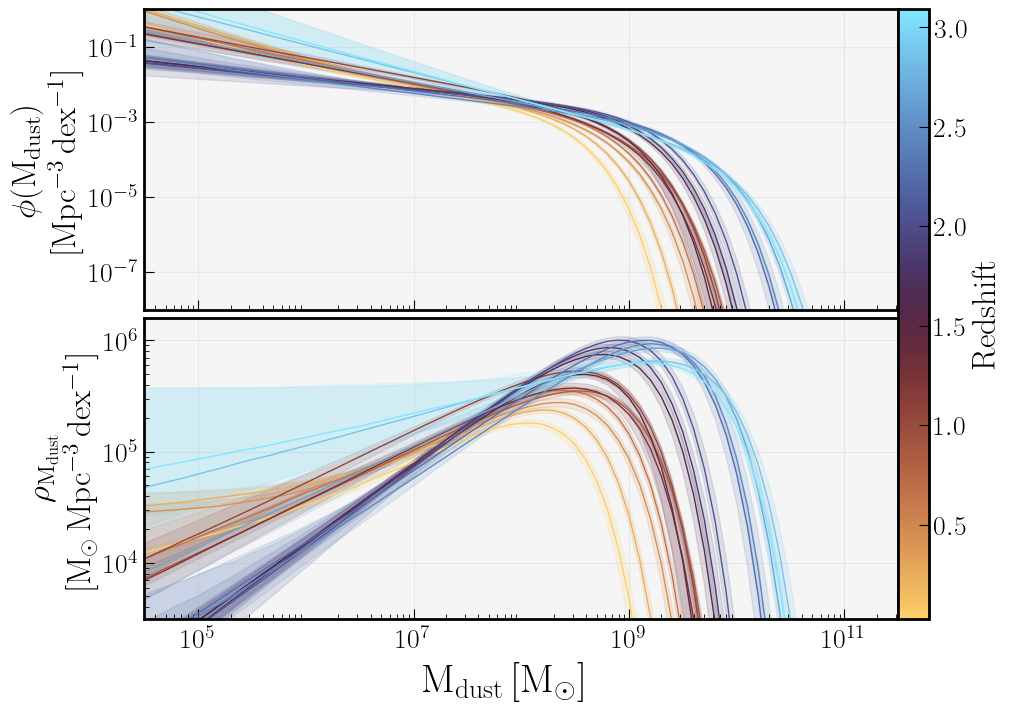

In [8]:
colours = get_n_colors(len(zmids), "managua")

fig, ax = plt.subplots(2, 1, figsize = (10, 7), constrained_layout = True, sharex = True)

for i in range(len(zmids)):
    ax[0].plot(
        dmf_fit[i]["x"],
        dmf_fit[i]["Q50"],
        lw = 1,
        color = colours[i],
        alpha = 1.0
    )   
    ax[0].fill_between(
        x = dmf_fit[i]["x"],
        y1 = dmf_fit[i]["Q16"],
        y2 = dmf_fit[i]["Q84"],
        color = colours[i],
        alpha = 0.15
    )    

    ax[1].plot(
        dmf_fit[i]["x"],
        dmf_fit[i]["Q50"] * dmf_fit[i]["x"],
        lw = 1,
        color = colours[i],
        alpha = 1.0
    )   
    ax[1].fill_between(
        x = dmf_fit[i]["x"],
        y1 = dmf_fit[i]["Q16"] * dmf_fit[i]["x"],
        y2 = dmf_fit[i]["Q84"] * dmf_fit[i]["x"],
        color = colours[i],
        alpha = 0.15
    )  

cmap = plt.cm.managua
norm = mpl.colors.Normalize(vmin=zmids.min(), vmax=zmids.max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.1, pad=0.0)
cbar.set_label("Redshift")

ax[0].set_facecolor('whitesmoke')  
ax[1].set_facecolor('whitesmoke')  

ax[0].grid(alpha = 0.2)

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim([10**4.4, 10**11.5])
ax[0].set_xticks([10**5.0, 10**7.0, 10**9.0, 10**11.0])
ax[0].set_ylim([1e-8, 1.0])
ax[0].set_yticks([10**-7, 10**-5, 10**-3, 10**-1])

ax[1].grid(alpha = 0.2)

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim([10**4.5, 10**11.5])
ax[1].set_xticks([10**5.0, 10**7.0, 10**9.0, 10**11.0])
ax[1].set_ylim([10**3.5, 10**6.2])


fig.supxlabel(r"$\mathrm{M_{dust} \, [M_{\odot}]}$")
ax[0].set_ylabel(r"$\mathrm{\phi(M_{dust})}$" + "\n" + r"$\mathrm{[Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)
ax[1].set_ylabel(r"$\mathrm{\rho_{M_{dust}}}$" + "\n" + r"$\mathrm{[M_{\odot} \, Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)

fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/dmf_z.pdf", dpi = 240)

## SMF

In [9]:
# colours = get_n_colors(len(zmids), "managua")

# fig, ax = plt.subplots(max([MidFactor(len(zmids)), len(zmids)/MidFactor(len(zmids))]), 
#                        min([MidFactor(len(zmids)), len(zmids)/MidFactor(len(zmids))]), 
#                        figsize = (15,15), constrained_layout = False, sharex=True, sharey=True)

# handles = []
# count = 0
# for i in range(ax.shape[0]):
#     for j in range(ax.shape[1]):

#         gama_handles = ax[i,j].scatter(
#             10**smf[count]["x"],
#             smf[count]["GAMA"],
#             color = "tab:purple",
#             marker = "x", 
#             alpha = 0.5,
#             s = 50,
#             label = "GAMA"
#         )
#         devils_handles = ax[i,j].scatter(
#             10**smf[count]["x"],
#             smf[count]["DEVILS"],
#             color = "tab:blue",
#             marker = "x",
#             alpha = 0.5,
#             s = 50,
#             label = "DEVILS"
#         )
#         if count == 1:
#             handles.append(gama_handles)
#             handles.append(devils_handles)
            
#         ax[i,j].errorbar(
#             10**smf[count]["x"][smf[count]["mlim"] == 1.0],
#             smf[count]["vmax"][smf[count]["mlim"] == 1.0],
#             yerr = smf[count]["vmaxErr"][smf[count]["mlim"] == 1.0], 
#             fmt = "o",
#             capsize = 2,
#             markerfacecolor = colours[count],
#             ecolor = "grey",
#             markeredgecolor = "grey",
#             alpha = 1.0
#         )
#         ax[i,j].scatter(
#             10**smf[count]["x"][smf[count]["mlim"] == 0.0],
#             smf[count]["vmax"][smf[count]["mlim"] == 0.0],
#             facecolor = "none",
#             edgecolor = colours[count]
#         )
#         ax[i,j].fill_between(
#             x = smf_fit[count]["x"],
#             y1 = smf_fit[count]["Q16"],
#             y2 = smf_fit[count]["Q84"],
#             color = colours[count],
#             alpha = 0.5
#         )

#         ax[i,j].text(
#             0.3, 0.85, f"{round(zbins[count],2)}" + "$ \\leq z <$" f"{round(zbins[count+1],2)}", 
#             transform = ax[i,j].transAxes, 
#             fontsize = 18, 
#             color = colours[count]
#         )
        
#         ax[i,j].set_facecolor('whitesmoke')  
#         ax[i,j].grid(color = "black", alpha = 0.1)

                
#         ax[i,j].set_xscale("log")
#         ax[i,j].set_yscale("log")
        
#         ax[i,j].set_xlim([10**6.5, 10**13.5])
#         ax[i,j].set_ylim([1e-8, 10.5])

#         ax[i,j].set_xticks([10**7.0, 10**9.0, 10**11.0, 10**13.0])
#         ax[i,j].set_yticks([10**-7, 10**-5, 10**-3, 10**-1, 10**1])

#         count += 1
        
# ax[0,0].legend(handles = handles, loc = "lower left", frameon = False, fontsize = 18)

# plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.supxlabel(r"$\mathrm{M_{\star} \, [M_{\odot}]}$", y = 0.05)
# fig.supylabel(r"$\mathrm{M_{\star}, density \, [Mpc^{-3} \, dex^{-1}]}$", x = 0.04)
# fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/smf.pdf", dpi = 240, bbox_inches='tight')

## SMF evol

In [10]:
# colours = get_n_colors(len(zmids), "managua")

# fig, ax = plt.subplots(2, 1, figsize = (10, 7), constrained_layout = True, sharex = True)

# for i in range(len(zmids)):
#     ax[0].plot(
#         smf_fit[i]["x"],
#         smf_fit[i]["Q50"],
#         lw = 1,
#         color = colours[i],
#         alpha = 1.0
#     )   
#     ax[0].fill_between(
#         x = smf_fit[i]["x"],
#         y1 = smf_fit[i]["Q16"],
#         y2 = smf_fit[i]["Q84"],
#         color = colours[i],
#         alpha = 0.15
#     )    

#     ax[1].plot(
#         smf_fit[i]["x"],
#         smf_fit[i]["Q50"] * smf_fit[i]["x"],
#         lw = 1,
#         color = colours[i],
#         alpha = 1.0
#     )   
#     ax[1].fill_between(
#         x = smf_fit[i]["x"],
#         y1 = smf_fit[i]["Q16"] * smf_fit[i]["x"],
#         y2 = smf_fit[i]["Q84"] * smf_fit[i]["x"],
#         color = colours[i],
#         alpha = 0.15
#     )  

# cmap = plt.cm.managua
# norm = mpl.colors.Normalize(vmin=zmids.min(), vmax=zmids.max())
# sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax, fraction=0.1, pad=0.0)
# cbar.set_label("Redshift")

# ax[0].set_facecolor('whitesmoke')  
# ax[1].set_facecolor('whitesmoke')  

# ax[0].grid(alpha = 0.2)

# ax[0].set_xscale("log")
# ax[0].set_yscale("log")
# ax[0].set_xlim([10**6.5, 10**13.2])
# ax[0].set_xticks([10**7.0, 10**9.0, 10**11.0, 10**13.0])
# ax[0].set_ylim([1e-8, 10.5])
# ax[0].set_yticks([10**-7, 10**-5, 10**-3, 10**-1, 10**1])

# ax[1].grid(alpha = 0.2)

# ax[1].set_xscale("log")
# ax[1].set_yscale("log")
# ax[1].set_xlim([10**6.5, 10**13.2])
# ax[1].set_xticks([10**7.0, 10**9.0, 10**11.0, 10**13.0])
# ax[1].set_ylim([10**6.2, 10**8.5])


# fig.supxlabel(r"$\mathrm{M_{\star} \, [M_{\odot}]}$")
# ax[0].set_ylabel(r"$\mathrm{\phi(M_{\star})}$" + "\n" + r"$\mathrm{[Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)
# ax[1].set_ylabel(r"$\mathrm{\rho_{M_{\star}}}$" + "\n" + r"$\mathrm{[M_{\odot} \, Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)

# fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/smf_z.pdf", dpi = 240)

In [11]:
# colours = get_n_colors(12, "managua")

# fig, ax = plt.subplots(4, 3, figsize = (15,10), constrained_layout = True, sharex=True, sharey=True)

# handles = []
# count = 0
# for i in range(ax.shape[0]):
#     for j in range(ax.shape[1]):

#         gama_handles = ax[i,j].scatter(
#             10**dlf[count]["x"],
#             dlf[count]["GAMA"],
#             color = "tab:purple",
#             marker = "x", 
#             alpha = 0.5,
#             s = 50,
#             label = "GAMA"
#         )
#         devils_handles = ax[i,j].scatter(
#             10**dlf[count]["x"],
#             dlf[count]["DEVILS"],
#             color = "tab:blue",
#             marker = "x",
#             alpha = 0.5,
#             s = 50,
#             label = "DEVILS"
#         )
#         if count == 1:
#             handles.append(gama_handles)
#             handles.append(devils_handles)
            
#         ax[i,j].errorbar(
#             10**dlf[count]["x"][dlf[count]["mlim"] == 1.0],
#             dlf[count]["vmax"][dlf[count]["mlim"] == 1.0],
#             yerr = dlf[count]["vmaxErr"][dlf[count]["mlim"] == 1.0], 
#             fmt = "o",
#             capsize = 2,
#             markerfacecolor = colours[count],
#             ecolor = "grey",
#             markeredgecolor = "grey",
#             alpha = 1.0
#         )
#         ax[i,j].scatter(
#             10**dlf[count]["x"][dlf[count]["mlim"] == 0.0],
#             dlf[count]["vmax"][dlf[count]["mlim"] == 0.0],
#             facecolor = "none",
#             edgecolor = colours[count]
#         )
#         ax[i,j].fill_between(
#             x = dlf_fit[count]["x"],
#             y1 = dlf_fit[count]["Q16"],
#             y2 = dlf_fit[count]["Q84"],
#             color = colours[count],
#             alpha = 0.5
#         )

#         ax[i,j].text(
#             0.5, 0.85, f"{round(zbins[count],2)}" + "$ \\leq z <$" f"{round(zbins[count+1],2)}", 
#             transform = ax[i,j].transAxes, 
#             fontsize = 18, 
#             color = colours[count]
#         )
        
#         ax[i,j].set_facecolor('whitesmoke')  
#         ax[i,j].grid(color = "black", alpha = 0.1)
        
#         ax[i,j].set_xlim([10**7.0, 10**14.0])
#         ax[i,j].set_ylim([1e-8, 1.0])
#         ax[i,j].set_xscale("log")
#         ax[i,j].set_yscale("log")
#         count += 1
# ax[0,0].legend(handles = handles, loc = "lower left", frameon = False, fontsize = 18)
# fig.supxlabel(r"$\mathrm{L_{dust} \, [L_{\odot}]}$")
# fig.supylabel(r"$\mathrm{\phi(L_{dust}) \, [Mpc^{-3} \, dex^{-1}]}$")

# fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/dlf.pdf", dpi = 240)

In [12]:
# colours = get_n_colors(12, "managua")

# fig, ax = plt.subplots(2, 1, figsize = (10, 7), constrained_layout = True, sharex = True)

# for i in range(len(zmids)):
#     ax[0].plot(
#         dlf_fit[i]["x"],
#         dlf_fit[i]["Q50"],
#         lw = 1,
#         color = colours[i],
#         alpha = 1.0
#     )   
#     ax[0].fill_between(
#         x = dlf_fit[i]["x"],
#         y1 = dlf_fit[i]["Q16"],
#         y2 = dlf_fit[i]["Q84"],
#         color = colours[i],
#         alpha = 0.15
#     )    

#     ax[1].plot(
#         dlf_fit[i]["x"],
#         dlf_fit[i]["Q50"] * dlf_fit[i]["x"],
#         lw = 1,
#         color = colours[i],
#         alpha = 1.0
#     )   
#     ax[1].fill_between(
#         x = dlf_fit[i]["x"],
#         y1 = dlf_fit[i]["Q16"] * dlf_fit[i]["x"],
#         y2 = dlf_fit[i]["Q84"] * dlf_fit[i]["x"],
#         color = colours[i],
#         alpha = 0.15
#     )  

# cmap = plt.cm.managua
# norm = mpl.colors.Normalize(vmin=zmids.min(), vmax=zmids.max())
# sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax, fraction=0.1, pad=0.0)
# cbar.set_label("Redshift")

# ax[0].set_facecolor('whitesmoke')  
# ax[1].set_facecolor('whitesmoke')

# ax[0].grid(alpha = 0.2)
# ax[0].set_xlim([10**7.0, 10**14.0])
# ax[0].set_ylim([1e-8, 1.0])
# ax[0].set_xscale("log")
# ax[0].set_yscale("log")

# ax[1].grid(alpha = 0.2)
# ax[1].set_xlim([10**7.0, 10**14.0])
# ax[1].set_ylim([10**6, 10**9])
# ax[1].set_xscale("log")
# ax[1].set_yscale("log")

# fig.supxlabel(r"$\mathrm{L_{dust} \, [L_{\odot}]}$")
# ax[0].set_ylabel(r"$\mathrm{\phi(L_{dust})}$" + "\n" + r"$\mathrm{[Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)
# ax[1].set_ylabel(r"$\mathrm{\rho_{L_{dust}}}$" + "\n" + r"$\mathrm{[L_{\odot} \, Mpc^{-3} \, dex^{-1}]}$", fontsize = 24)

# fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/dlf_z.pdf", dpi = 240)

# Compare ProSpect and Magphys

In [13]:
FinalSample = pd.read_hdf(h5file, "Photometry/FinalSample")
WeightedSpec = pd.read_hdf(h5file, "Photometry/WeightedSpec")

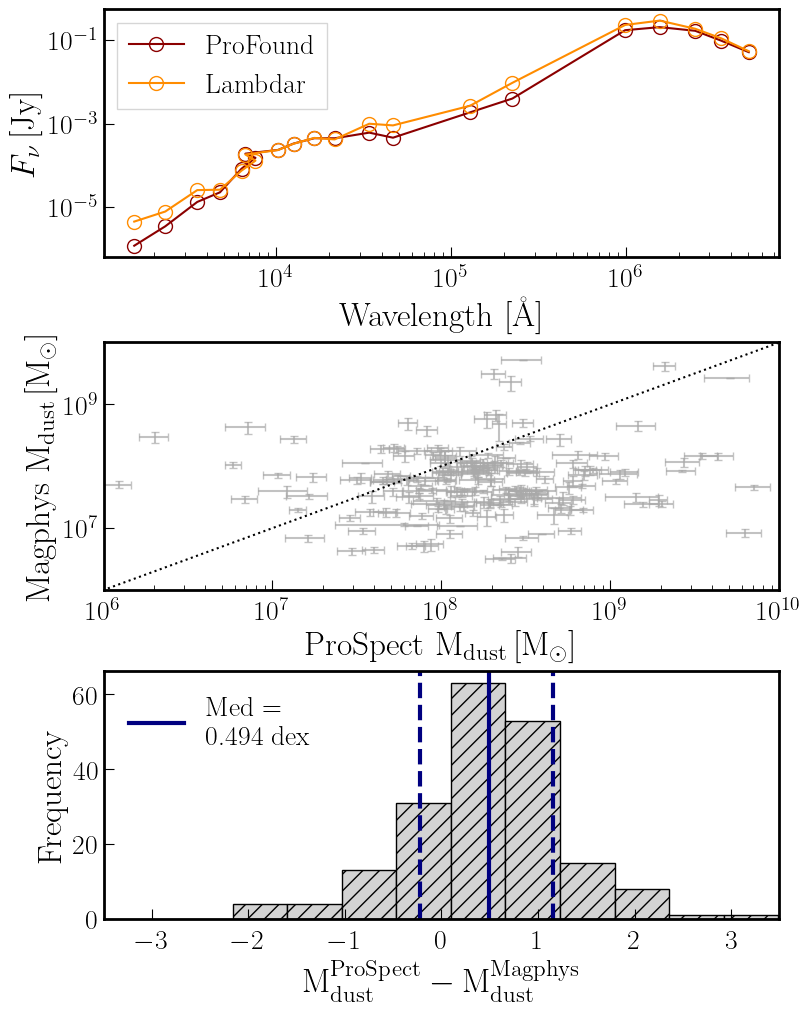

In [14]:
fig, ax = plt.subplots(3, 1, figsize = (8,10), constrained_layout = True)
ax[0].plot(
    WeightedSpec["wavelength"], WeightedSpec["ProFoundStack"], 
    marker = "o", markeredgecolor = "darkred", markerfacecolor = "none", markersize = 10,
    color = "darkred",
    label = "ProFound"
)
ax[0].plot(
    WeightedSpec["wavelength"], WeightedSpec["LambdarStack"], 
    marker = "o", markeredgecolor = "darkorange", markerfacecolor = "none", markersize = 10,
    color = "darkorange",
    label = "Lambdar"
)
ax[0].legend(frameon = True, fancybox = False, fontsize = 20)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r"Wavelength [Å]")
ax[0].set_ylabel(r"$F_{\nu} \, [\mathrm{Jy}]$")

ax[1].errorbar(
    FinalSample["MdustProSpect"],
    FinalSample["MdustMagphys"],
    xerr = FinalSample["MdustErrProSpect"],
    yerr = FinalSample["MdustErrMagphys"],
    fmt = "none",
    markeredgecolor = "darkgrey",
    markerfacecolor = "white", 
    ecolor = "darkgrey",
    capsize = 3,
    alpha = 0.7
)
ax[1].plot(10**np.arange(3.5,12.5,0.5), 10**np.arange(3.5,12.5,0.5), color = "black", ls = ":")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim([10**6,10**10])
ax[1].set_ylim([10**6,10**10])
ax[1].set_xlabel(r"ProSpect $\mathrm{M_{dust} \, [M_{\odot}]}$")
ax[1].set_ylabel(r"Magphys $\mathrm{M_{dust} \, [M_{\odot}]}$")

ax[2].hist(
    np.log10(FinalSample["MdustProSpect"]) - np.log10(FinalSample["MdustMagphys"]), 
    edgecolor = "black", facecolor = "lightgrey", hatch = "//"
)
ax[2].axvline(
    np.median(np.log10(FinalSample["MdustProSpect"]) - np.log10(FinalSample["MdustMagphys"])), 
    linewidth = 3, color = "navy", 
    label = "Med = \n   " + f"{np.median(np.log10(FinalSample["MdustProSpect"]) - np.log10(FinalSample["MdustMagphys"])):.3f}" + " dex"
)
ax[2].axvline(
    np.quantile(np.log10(FinalSample["MdustProSpect"]) - np.log10(FinalSample["MdustMagphys"]), 0.16), 
    linewidth = 3, color = "navy", ls = "--"
)
ax[2].axvline(
    np.quantile(np.log10(FinalSample["MdustProSpect"]) - np.log10(FinalSample["MdustMagphys"]), 0.84), 
    linewidth = 3, color = "navy", ls = "--"
)
ax[2].legend(frameon = False, fontsize = 20, loc = "upper left")
ax[2].set_xlim(-3.5, 3.5)
ax[2].set_xlabel(r"$\mathrm{M_{dust}^{ProSpect} - M_{dust}^{Magphys}}$")
ax[2].set_ylabel(r"Frequency")

# ax[2].errorbar(
#     WeightedSpec["wavelength"], WeightedSpec["ProFoundStack"], yerr = WeightedSpec["ProFoundErr"], 
#     fmt = "o", markeredgecolor = "tab:orange", ecolor = "tab:orange", markerfacecolor = "none", 
#     label = "ProFound"
# )
# ax[2].errorbar(
#     WeightedSpec["wavelength"], WeightedSpec["LambdarStack"], yerr = WeightedSpec["LambdarErr"],
#     fmt = "o", markeredgecolor = "tab:red", ecolor = "tab:red", markerfacecolor = "none",
#     label = "Lambdar"
# )

fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/magphys_propsect.pdf", bbox_inches = "tight", dpi = 240)

# Dale vs. Magphys

In [15]:
AstroSamples = pd.read_hdf(h5file, "DaleMagphys/Samples")
SpecSamples = pd.read_hdf(h5file, "DaleMagphys/Spec")
StandardSpec = pd.read_hdf(h5file, "DaleMagphys/StandardSpec")

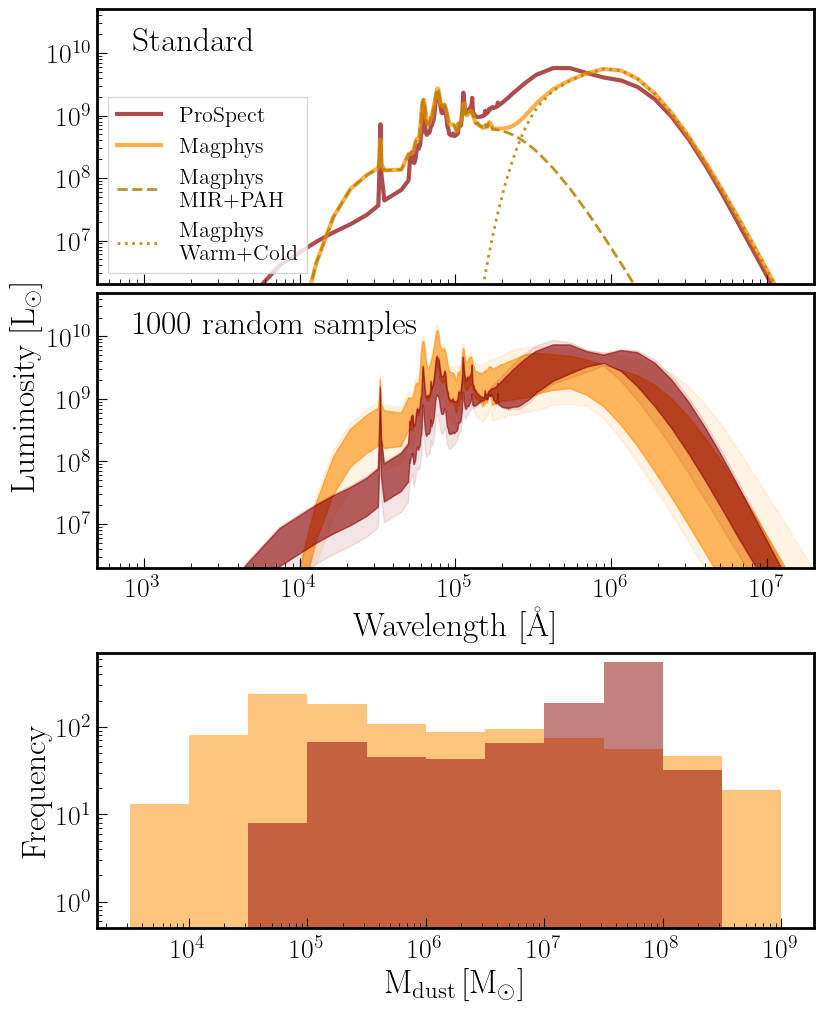

In [16]:
# fig, ax = plt.subplots(3, 1, figsize = (8,10), constrained_layout = True)
fig = plt.figure(figsize = (8,10), constrained_layout = True)

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2, sharex = ax1, sharey = ax1)
ax3 = fig.add_subplot(3, 1, 3)
ax = [ax1, ax2, ax3]

ax[0].plot(
    StandardSpec["wave"], StandardSpec["Dale"] * StandardSpec["wave"], 
    color = "darkred", lw = 3, alpha = 0.7, label = "ProSpect"
)
ax[0].plot(
    StandardSpec["wave"], StandardSpec["Magphys"] * StandardSpec["wave"], 
    color = "darkorange", lw = 3, alpha = 0.7, label = "Magphys"
)
ax[0].plot(
    StandardSpec["wave"], (StandardSpec["MagphysBC_MIR"]+StandardSpec["MagphysBC_PAH"]+StandardSpec["MagphysISM_MIR"]+StandardSpec["MagphysISM_PAH"]) * StandardSpec["wave"], 
    color = "darkgoldenrod", lw = 2, alpha = 0.9, ls = "--", label = "Magphys \n MIR+PAH"
)
ax[0].plot(
    StandardSpec["wave"], (StandardSpec["MagphysBC_WBC"]+StandardSpec["MagphysISM_CISM"]+StandardSpec["MagphysISM_WISM"]) * StandardSpec["wave"], 
    color = "darkgoldenrod", lw = 2, alpha = 0.9, ls = ":", label = "Magphys \n Warm+Cold"
)
ax[0].text(0.05, 0.85, "Standard", transform = ax[0].transAxes)
ax[0].legend(frameon = True, fancybox = False, fontsize = 16, ncol = 1, loc = "lower left")

# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysBC_MIR"] * StandardSpec["wave"], 
#     color = "orange", lw = 1, alpha = 0.9, ls = ":"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysBC_PAH"] * StandardSpec["wave"], 
#     color = "orange", lw = 1, alpha = 0.9, ls = ":"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysBC_WBC"] * StandardSpec["wave"], 
#     color = "orange", lw = 1, alpha = 0.9, ls = ":"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysISM_CISM"] * StandardSpec["wave"], 
#     color = "tab:orange", lw = 1, alpha = 0.9, ls = "--"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysISM_MIR"] * StandardSpec["wave"], 
#     color = "tab:orange", lw = 1, alpha = 0.9, ls = "--"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysISM_PAH"] * StandardSpec["wave"], 
#     color = "tab:orange", lw = 1, alpha = 0.9, ls = "--"
# )
# ax[0].plot(
#     StandardSpec["wave"], StandardSpec["MagphysISM_WISM"] * StandardSpec["wave"], 
#     color = "tab:orange", lw = 1, alpha = 0.9, ls = "--"
# )
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xlim([5e2,2e7])
ax[0].set_ylim([2e6, 5e10])
ax[0].set_xticklabels([])
plt.setp(ax[0].get_xticklabels(), visible=False)
# ax[0].set_xlabel("Wavelength [Å]")
# ax[0].set_ylabel("Luminosity $[\\mathrm{L_{\\odot}}]$")

ax[1].fill_between(
    SpecSamples["wave"], SpecSamples["MagphysQ05"]*SpecSamples["wave"],  SpecSamples["MagphysQ95"]*SpecSamples["wave"], color = "darkorange", alpha = 0.1
)
ax[1].fill_between(
    SpecSamples["wave"], SpecSamples["MagphysQ16"]*SpecSamples["wave"],  SpecSamples["MagphysQ84"]*SpecSamples["wave"], color = "darkorange", alpha = 0.6
)
ax[1].fill_between(
    SpecSamples["wave"], SpecSamples["DaleQ05"]*SpecSamples["wave"],  SpecSamples["DaleQ95"]*SpecSamples["wave"], color = "darkred", alpha = 0.1
)
ax[1].fill_between(
    SpecSamples["wave"], SpecSamples["DaleQ16"]*SpecSamples["wave"],  SpecSamples["DaleQ84"]*SpecSamples["wave"], color = "darkred", alpha = 0.6
)
ax[1].text(0.05, 0.85, "1000 random samples", transform = ax[1].transAxes)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim([5e2,2e7])
ax[1].set_ylim([2e6, 5e10])
ax[1].set_xlabel("Wavelength [Å]")
# ax[1].set_ylabel("Luminosity $[\\mathrm{L_{\\odot}}]$")
fig.text(-0.01, 0.62, 'Luminosity $[\\mathrm{L_{\\odot}}]$', va='center', rotation='vertical')

ax[2].hist(
    (AstroSamples["MagphysMdust"]), 
    bins = 10**np.arange(3.5, 9.5, 0.5),
    color = "darkorange", alpha = 0.5
)
ax[2].hist(
    (AstroSamples["DaleMdust"]), 
    bins = 10**np.arange(3.5, 9.5, 0.5),
    color = "darkred", alpha = 0.5
)
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim([0.5,700])
ax[2].set_xlabel(r"$\mathrm{M_{dust} \, [M_{\odot}]}$")
ax[2].set_ylabel(r"Frequency")

fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/magphys_dale_samples.pdf", dpi = 240, bbox_inches = "tight")

In [17]:
Md_corr = np.median(AstroSamples["MagphysLum"]/AstroSamples["MagphysLumNoPAH"]) * np.median(AstroSamples["DaleFIR"]/AstroSamples["MagphysFIR"])
print(f"Average difference = {Md_corr:.3f}")

Average difference = 3.009


# Cosmic densities

In [18]:
with h5py.File(h5file, "r") as f:
    zmids = np.array( f["zmids"][:] )  
    zbins = np.array( f["zbins"][:] )  
    lbtmids = np.array( f["lbtmids"][:] )  
    lbtbins = np.array( f["lbtbins"][:] )  
    LSSCorrection = np.array( f["LSSCorrection"][:] )  
    # rhoH = np.array( f["hydrogenDensity"][:] )   

In [19]:
cosmic_Mdust = pd.read_hdf(h5file, "cosmic/Mdust")
cosmic_Mdust_gama = pd.read_hdf(h5file, "cosmic/Mdust_gama")
cosmic_Mdust_devils = pd.read_hdf(h5file, "cosmic/Mdust_devils")
cosmic_MdustwAGN = pd.read_hdf(h5file, "cosmic/MdustwAGN")
cosmic_Mstar = pd.read_hdf(h5file, "cosmic/Mstar")

In [20]:
driver18 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/cdmh/driver18.csv")

dsilva25 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/csfh/DSilva25_CSFH_CAGNH_fit.csv")
driver18_csmd = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/csmh/driver2018.csv")

dunne11 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/cdmh/dunne11.csv")
pozzi20 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/cdmh/pozzi20.csv")
beeston24 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/cdmh/beeston24.csv")
chiang25 = pd.read_csv("/Users/22252335/Documents/DustMassDensity/data/literature_evo/cdmh/chiang25.csv")

# driver25_ebl_dust = pd.read_csv("/Users/22252335/Desktop/simon_dust.csv")

## Dust mass density

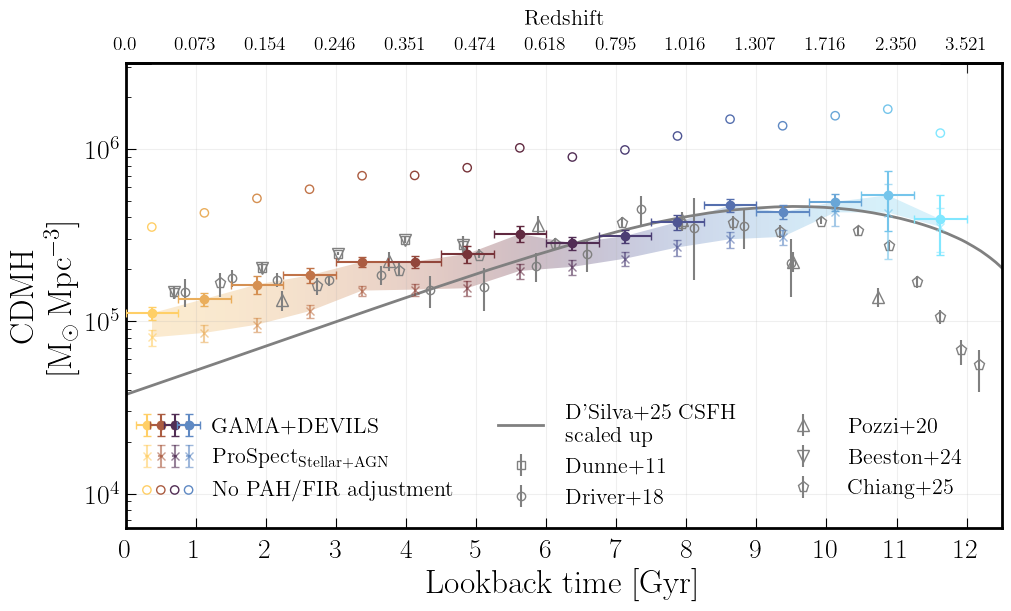

In [28]:
colours = get_n_colors(len(zmids), "managua")

fig, ax = plt.subplots(1, 1, figsize = (10, 6), constrained_layout = True)

Md_corr = 10**0.5

dust_handles = []
dustwAGN_handles = []
no_corr_handles = []

arr = [[0, 1], [0, 1]]
im1 = ax.imshow(
    arr, 
    cmap = mpl.cm.managua, 
    extent = [min(lbtmids), max(lbtmids), 1e3, 1e7], 
    interpolation = "bicubic", 
    alpha = .3, 
    aspect = "auto"
)
ax.fill_between(
    lbtmids, 
    np.maximum(cosmic_Mdust["Q50"]*LSSCorrection, cosmic_MdustwAGN["Q50"]*LSSCorrection) / Md_corr,
    1e8*np.ones(len(lbtmids)), 
    facecolor='white', 
    interpolate=True
)
ax.fill_between(
    lbtmids, 
    np.minimum(cosmic_Mdust["Q50"]*LSSCorrection, cosmic_MdustwAGN["Q50"]*LSSCorrection) / Md_corr,
    1e3*np.ones(len(lbtmids)), 
    facecolor='white', 
    interpolate=True
)

for i in range(len(zmids)):

    no_correction = ax.scatter(
        lbtmids[i], cosmic_Mdust["Q50"][i] * LSSCorrection[i], 
        edgecolor = colours[i], 
        facecolor = "none"
    )
    
    dust_leg = ax.errorbar(
        lbtmids[i], 
        cosmic_Mdust["Q50"][i] * LSSCorrection[i] / Md_corr, 
        xerr = abs(lbtbins[1] - lbtbins[0])/2.0,
        yerr = cosmic_Mdust["ERR"][i] * LSSCorrection[i] / Md_corr,
        color = colours[i],
        marker = "o",
        capsize = 3, 
        zorder = 10
    )
    dustwAGN_leg = ax.errorbar(
        lbtmids[i], 
        cosmic_MdustwAGN["Q50"][i] * LSSCorrection[i] / Md_corr, 
        yerr = cosmic_MdustwAGN["ERR"][i] * LSSCorrection[i] / Md_corr,
        color = colours[i],
        marker = "x",
        alpha = 0.6,
        capsize = 3,
        zorder = 10
    )

    if i % MidFactor(len(zmids)) == 0:
        dust_handles.append(dust_leg)
        dustwAGN_handles.append(dustwAGN_leg)
        no_corr_handles.append(no_correction)
        # dust_lim_handles.append(uplim_)

driver18_ = ax.errorbar(
    driver18["lbt"],
    driver18["cdmh"],
    yerr = driver18["err"],
    fmt = "o",
    capsize = 0,
    markeredgecolor = "grey",
    markerfacecolor = "none",
    ecolor = "grey",
    label = "Driver+18"
)
dunne11_ = ax.errorbar(
    Planck18.lookback_time(dunne11["z"]).value,
    dunne11["cdmh"],
    yerr = dunne11["err"],
    fmt = "s",
    capsize = 0,
    markeredgecolor = "grey",
    markerfacecolor = "none",
    ecolor = "grey",
    label = "Dunne+11"
)
pozzi20_ = ax.errorbar(
    Planck18.lookback_time(pozzi20["z"]).value,
    pozzi20["cdmh"],
    yerr = pozzi20["err"],
    fmt = "^",
    capsize = 0,
    markersize = 8,
    markeredgecolor = "grey",
    markerfacecolor = "none",
    ecolor = "grey",
    label = "Pozzi+20"
)
beeston24_ = ax.errorbar(
    Planck18.lookback_time(beeston24["z"]).value,
    beeston24["cdmh"],
    yerr = beeston24["err"],
    fmt = "v",
    capsize = 0,
    markersize = 8,
    markeredgecolor = "grey",
    markerfacecolor = "none",
    ecolor = "grey",
    label = "Beeston+24"
)
chiang25_ = ax.errorbar(
    Planck18.lookback_time(chiang25["z"]).value,
    chiang25["cdmh"],
    yerr = [chiang25["errlo"],chiang25["errhi"]],
    fmt = "p",
    capsize = 0,
    markersize = 8,
    markeredgecolor = "grey",
    markerfacecolor = "none",
    ecolor = "grey",
    label = "Chiang+25"
)

dsilva25_csfh_, = ax.plot(
    Planck18.lookback_time(dsilva25["z"]).value,
    pow(10, dsilva25["CSFHQ50"]) * 6e6, 
    lw = 2, 
    color = "grey", 
    label = "D'Silva+25 CSFH \n scaled up"
)

ax.grid(
    alpha = 0.2
)

ax.legend(
    handles = [
        tuple(dust_handles), 
        tuple(dustwAGN_handles), 
        tuple(no_corr_handles),
        dsilva25_csfh_, 
        dunne11_,
        driver18_,
        pozzi20_,
        beeston24_,
        chiang25_
    ], 
    labels = [
        "GAMA+DEVILS", 
        r"$\mathrm{ProSpect_{Stellar+AGN}}$", 
        "No PAH/FIR adjustment",
        dsilva25_csfh_.get_label(), 
        dunne11_.get_label(),
        driver18_.get_label(),
        pozzi20_.get_label(),
        beeston24_.get_label(),
        chiang25_.get_label()
    ], 
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
    handletextpad=1.0,
    fontsize = 16,
    frameon = False, 
    fancybox = False, 
    ncol = 3,
    facecolor = "whitesmoke"
)

ax.set_xlim([0,12.5])
ax.set_xticks([0.0,1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_ylim([10**3.8, 10**6.5])
ax.set_yscale("log")

ax_top = ax.secondary_xaxis('top')
z_ticks = z_at_value(Planck18.lookback_time, np.array([0.0001,1,2,3,4,5,6,7,8,9,10,11,12]) * u.Gyr)
ax_top.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
ax_top.set_xticklabels([f"{a:.1f}" if i==0 else f"{a:.3f}" for i,a in enumerate(z_ticks.value)], fontsize = 14, rotation = 0)
ax_top.set_xlabel("Redshift", labelpad=8.0, fontsize = 16)

ax.set_xlabel("Lookback time [Gyr]")
ax.set_ylabel(r"$\mathrm{CDMH}$" + "\n" + r"$\mathrm{[M_{\odot} \, Mpc^{-3}]}$", fontsize = 24)
fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/cosmic_dust.pdf", dpi = 240)

## Stellar mass density

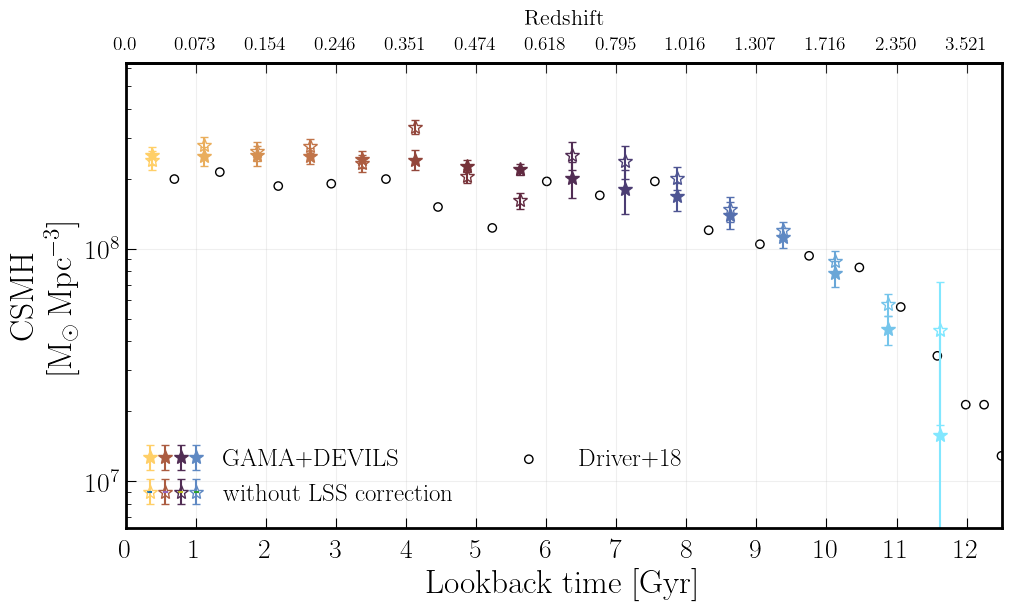

In [22]:
colours = get_n_colors(len(zmids), "managua")

fig, ax = plt.subplots(1, 1, figsize = (10, 6), constrained_layout = True)

mstar_handles = []
mstar_lss_handles = []

for i in range(len(zmids)):
    mstar_ = ax.errorbar(
        lbtmids[i], 
        cosmic_Mstar["Q50_lim"][i] * LSSCorrection[i], 
        yerr = cosmic_Mstar["ERR"][i],
        color = colours[i],
        marker = "*",
        markersize = 10,
        capsize = 3
    )

    mstar_lss_ = ax.errorbar(
        lbtmids[i], 
        cosmic_Mstar["Q50"][i], 
        yerr = cosmic_Mstar["ERR"][i],
        ecolor = colours[i],
        markeredgecolor = colours[i],
        markerfacecolor = "none",
        marker = "*",
        markersize = 10,
        capsize = 3
    )
    if i % MidFactor(len(zmids)) == 0:
        mstar_handles.append(mstar_)
        mstar_lss_handles.append(mstar_lss_)

driver18_ = ax.scatter(
    Planck18.lookback_time(driver18_csmd["z"]).value,
    10**driver18_csmd["csmd"], 
    edgecolor = "black",
    facecolor = "none", 
    label = "Driver+18"
)

ax.grid(alpha = 0.2)

ax.legend(
    handles = [tuple(mstar_handles), tuple(mstar_lss_handles), driver18_], 
    labels = ["GAMA+DEVILS", "without LSS correction", driver18_.get_label()], 
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
    handletextpad=1.0,
    fontsize = 18,
    frameon = False, 
    fancybox = False, 
    ncol = 2,
    facecolor = "whitesmoke"
)
ax.set_xlim([0,12.5])
ax.set_xticks([0.0,1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_ylim([10**6.8, 10**8.8])
ax.set_yscale("log")

ax_top = ax.secondary_xaxis('top')
z_ticks = z_at_value(Planck18.lookback_time, np.array([0.0001,1,2,3,4,5,6,7,8,9,10,11,12]) * u.Gyr)
ax_top.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
ax_top.set_xticklabels([f"{a:.1f}" if i==0 else f"{a:.3f}" for i,a in enumerate(z_ticks.value)], fontsize = 14, rotation = 0)
ax_top.set_xlabel("Redshift", labelpad=8.0, fontsize = 16)

ax.set_xlabel("Lookback time [Gyr]")
ax.set_ylabel(r"$\mathrm{CSMH}$" + "\n" + r"$\mathrm{[M_{\odot} \, Mpc^{-3}]}$", fontsize = 24)

fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/csmh.pdf", dpi = 240, bbox_inches = 'tight')

# Omega

In [37]:
omega = pd.read_hdf(h5file, "Omega")

In [34]:
peroux20_NeutralGas = pd.read_csv(
    "/Users/22252335/Documents/DustMassDensity/data/literature_evo/omega/aa58_peroux_suppl_tables/Peroux_SupplementalTable1_Fig3.asc",
    sep=r'\s+',
    engine='python',
    comment = "#", 
    skiprows=1
)
peroux20_Metals = pd.read_csv(
    "/Users/22252335/Documents/DustMassDensity/data/literature_evo/omega/aa58_peroux_suppl_tables/Peroux_SupplementalTable5_Fig8.asc",
    sep=r'\s+',
    engine='python',
    comment = "#", 
    skiprows=1
)
peroux20_Dust = pd.read_csv(
    "/Users/22252335/Documents/DustMassDensity/data/literature_evo/omega/aa58_peroux_suppl_tables/Peroux_SupplementalTable6_Fig12.asc",
    sep=r'\s+',
    engine='python',
    comment = "#", 
    skiprows=1
)

peroux20_Metals = peroux20_Metals[~(peroux20_Metals["Category"] == "Star")]

In [86]:
2.17 * 1e-3 / 0.04787798

0.04532354957331115

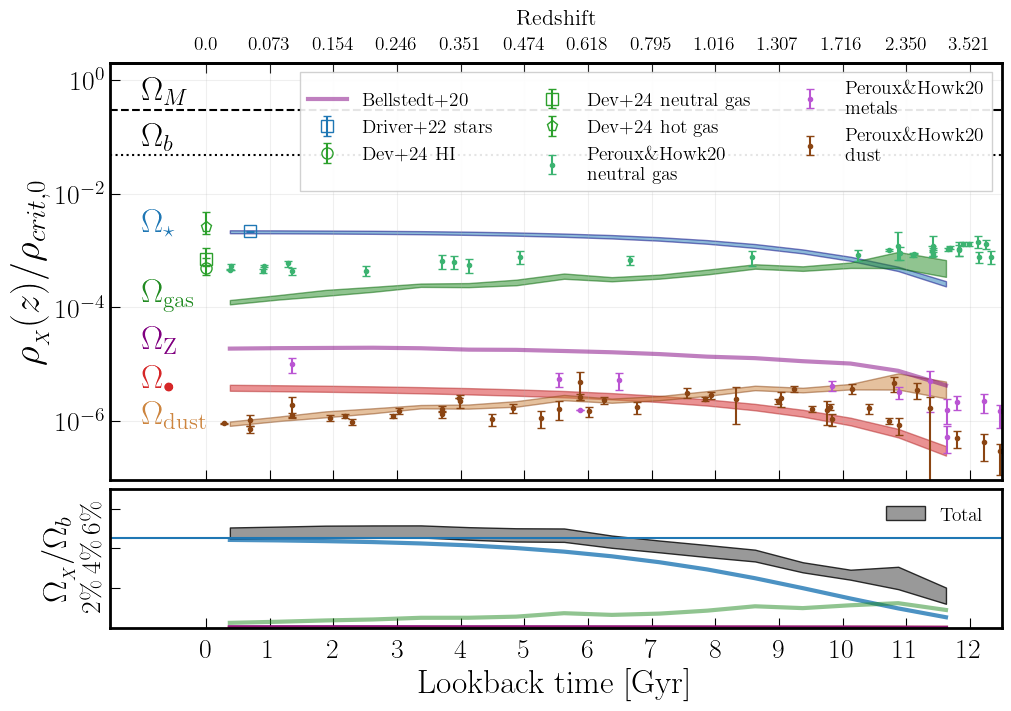

In [91]:
fig, ax = plt.subplots(2, 1, figsize = (10, 7), constrained_layout = True, height_ratios = [3,1], sharex=True)
ax,ax1 = ax
ax.fill_between(
    lbtmids, 
    omega["OmegaStarQ16"], omega["OmegaStarQ84"],
    facecolor='tab:blue', 
    edgecolor = "navy",
    alpha = 0.5
)
ax.fill_between(
    lbtmids, 
    omega["OmegaBHQ16"], omega["OmegaBHQ84"],
    facecolor='tab:red', 
    edgecolor = "firebrick",
    alpha = 0.5
)
ax.fill_between(
    lbtmids, 
    omega["OmegaDustQ16"], omega["OmegaDustQ84"],
    facecolor='peru', 
    edgecolor = "saddlebrown",
    alpha = 0.5
)
ax.fill_between(
    lbtmids, 
    omega["OmegaDustQ16"]/0.0073, omega["OmegaDustQ84"]/0.0073,
    facecolor='forestgreen', 
    edgecolor = "darkgreen",
    alpha = 0.5
)
ax.plot(
    lbtmids, 
    omega["OmegaZgas"],
    color='purple', 
    lw = 3,
    alpha = 0.5, 
    label = "Bellstedt+20"
)
ax.axhline(0.04787798, color = "black", ls = ":")
ax.axhline(0.301, color = "black", ls = "--")

## literature 
# ax.errorbar(
#     0.1, 
#     2.09 * 1e-3, 
#     yerr = [[0.18 * 1e-3], [0.21 * 1e-3]],
#     markerfacecolor = "none",
#     markeredgecolor = "tab:blue", 
#     ecolor = "tab:blue",
#     fmt = "o", 
#     capsize = 3, 
#     markersize = 8,
#     label = "Dev+24 stars"
# )
ax.errorbar(
    Planck18.lookback_time(0.05).value, 
    2.17 * 1e-3, 
    yerr = [[0.03 * 1e-3], [0.03 * 1e-3]],
    markerfacecolor = "none",
    markeredgecolor = "tab:blue", 
    ecolor = "tab:blue",
    fmt = "s", 
    capsize = 3, 
    markersize = 8,
    label = "Driver+22 stars"
)

ax.errorbar(
    0, 
    0.49 * 1e-3, 
    yerr = [[0.12 * 1e-3], [0.25 * 1e-3]],
    markerfacecolor = "none",
    markeredgecolor = "tab:green", 
    ecolor = "tab:green",
    fmt = "o", 
    capsize = 3,
    markersize = 8,
    label = "Dev+24 HI"
)
# ax.errorbar(
#     Planck18.lookback_time(0.32).value, 
#     0.5 * 1e-3, 
#     yerr = [[0.18 * 1e-3], [0.18 * 1e-3]],
#     markerfacecolor = "none",
#     markeredgecolor = "darkgreen", 
#     ecolor = "darkgreen",    
#     fmt = "o", 
#     capsize = 3,
#     label = "Rhee+24 HI"
# )
ax.errorbar(
    0, 
    0.71 * 1e-3, 
    yerr = [[0.18 * 1e-3], [0.39 * 1e-3]],
    markerfacecolor = "none",
    markeredgecolor = "tab:green", 
    ecolor = "tab:green",    fmt = "s", 
    capsize = 3,
    markersize = 8,
    label = "Dev+24 neutral gas"
)
ax.errorbar(
    0, 
    2.58 * 1e-3, 
    yerr = [[0.66 * 1e-3], [2.1 * 1e-3]],
    markerfacecolor = "none",
    markeredgecolor = "tab:green", 
    ecolor = "tab:green",    
    fmt = "p", 
    capsize = 3,
    markersize = 8,
    label = "Dev+24 hot gas"
)
ax.errorbar(
    Planck18.lookback_time(peroux20_NeutralGas["z"]).value,
    peroux20_NeutralGas["Omega_NeutralGas"] * 1e-3,
    yerr = [peroux20_NeutralGas["errm_Omega_NeutralGas"]*1e-3, 
            peroux20_NeutralGas["errp_Omega_NeutralGas"]*1e-3],
    capsize = 3,
    ls = "",
    fmt = ".",
    color = "mediumseagreen", 
    label = r"Peroux\&Howk20" + " \n neutral gas"
)
ax.errorbar(
    Planck18.lookback_time(peroux20_Metals["z_mid"]).value,
    10**peroux20_Metals["logOmega_Metals"],
    yerr = [peroux20_Metals["errm_logOmega_Metals"]*10**peroux20_Metals["logOmega_Metals"]*np.log(10), 
            peroux20_Metals["errp_logOmega_Metals"]*10**peroux20_Metals["logOmega_Metals"]*np.log(10)],
    capsize = 3,
    ls = "",
    fmt = ".",
    color = "mediumorchid", 
    label = r"Peroux\&Howk20" + "\n metals"
)
ax.errorbar(
    Planck18.lookback_time(peroux20_Dust["z"]).value,
    10**peroux20_Dust["logOmega_Dust"],
    yerr = [peroux20_Dust["errm_logOmega_Dust"]*10**peroux20_Dust["logOmega_Dust"]*np.log(10), 
            peroux20_Dust["errp_logOmega_Dust"]*10**peroux20_Dust["logOmega_Dust"]*np.log(10)],
    capsize = 3,
    ls = "",
    fmt = ".",
    color = "saddlebrown", 
    label = r"Peroux\&Howk20" + "\n dust"
)

ax.legend(frameon = True, fontsize = 14, fancybox = False, framealpha = 0.9, ncol = 3)

ax.text(-1.0, 0.301*1.5, "$\\Omega_{M}$")
ax.text(-1.0, 0.04787798*1.5, "$\\Omega_{b}$")
ax.text(-1.0, omega["OmegaStarQ50"][0], "$\\Omega_{\\star}$", color = "tab:blue")
ax.text(-1.0, omega["OmegaDustQ50"][0]/0.0073, "$\\Omega_{\\mathrm{gas}}$", color = "forestgreen")
ax.text(-1.0, omega["OmegaZgas"][0], "$\\Omega_{\\mathrm{Z}}$", color = "purple")
ax.text(-1.0, omega["OmegaBHQ50"][0], "$\\Omega_{\\bullet}$", color = "tab:red")
ax.text(-1.0, omega["OmegaDustQ50"][0], "$\\Omega_{\\mathrm{dust}}$", color = "peru")

ax_top = ax.secondary_xaxis('top')
z_ticks = z_at_value(Planck18.lookback_time, np.array([0.0001,1,2,3,4,5,6,7,8,9,10,11,12]) * u.Gyr)
ax_top.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
ax_top.set_xticklabels([f"{a:.1f}" if i==0 else f"{a:.3f}" for i,a in enumerate(z_ticks.value)], fontsize = 14, rotation = 0)
ax_top.set_xlabel("Redshift", labelpad=8.0, fontsize = 16)

ax.grid(alpha = 0.2)
ax.set_yscale("log")

ax.set_xlim([-1.5,12.5])
ax.set_xticks([0.0,1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_ylim([9e-8, 2.0])

ax1.set_xlabel("Lookback time [Gyr]")
ax.set_ylabel(r"$\rho_{_{X}}(z)/\rho_{crit,0}$", fontsize = 28)

# ax1.fill_between(
#     lbtmids, 
#     omega["OmegaStarQ16"]/0.04787798, omega["OmegaStarQ84"]/0.04787798,
#     facecolor='tab:blue', 
#     edgecolor = "navy",
#     alpha = 0.5
# )
# ax1.fill_between(
#     lbtmids, 
#     omega["OmegaBHQ16"]/0.04787798, omega["OmegaBHQ84"]/0.04787798,
#     facecolor='tab:red', 
#     edgecolor = "firebrick",
#     alpha = 0.5
# )
# ax1.fill_between(
#     lbtmids, 
#     omega["OmegaDustQ16"]/0.04787798, omega["OmegaDustQ84"]/0.04787798,
#     facecolor='peru', 
#     edgecolor = "saddlebrown",
#     alpha = 0.5
# )
# ax1.fill_between(
#     lbtmids, 
#     omega["OmegaDustQ16"]/0.0073/0.04787798, omega["OmegaDustQ84"]/0.0073/0.04787798,
#     facecolor='forestgreen', 
#     edgecolor = "darkgreen",
#     alpha = 0.5
# )
# ax1.plot(
#     lbtmids, 
#     omega["OmegaZgas"]/0.04787798,
#     color='purple', 
#     lw = 3,
#     alpha = 0.5
# )
# ax1.fill_between(
#     lbtmids,
#     (omega["OmegaStarQ16"] + omega["OmegaBHQ16"] + omega["OmegaDustQ16"] + omega["OmegaZgas"] + omega["OmegaDustQ16"]/0.0073)/0.04787798,
#     (omega["OmegaStarQ84"] + omega["OmegaBHQ84"] + omega["OmegaDustQ84"] + omega["OmegaZgas"] + omega["OmegaDustQ84"]/0.0073)/0.04787798,
#     edgecolor = "black", facecolor = "grey", alpha = 0.8
# )

ax1.plot(
    lbtmids, 
    omega["OmegaStarQ50"]/0.04787798 * 100,
    color='tab:blue', 
    alpha = 0.8, 
    lw = 3
)
ax1.plot(
    lbtmids, 
    omega["OmegaBHQ50"]/0.04787798 * 100,
    color='tab:red', 
    alpha = 0.8,
    lw = 3
)
ax1.plot(
    lbtmids, 
    omega["OmegaDustQ50"]/0.04787798 * 100,
    color='peru', 
    alpha = 0.8,
    lw = 3
)
ax1.plot(
    lbtmids, 
    omega["OmegaDustQ50"]/0.0073/0.04787798 * 100,
    color='forestgreen', 
    alpha = 0.5,
    lw = 3
)
ax1.plot(
    lbtmids, 
    omega["OmegaZgas"]/0.04787798 * 100,
    color='purple', 
    alpha = 0.8,
    lw = 3
)
ax1.fill_between(
    lbtmids,
    (omega["OmegaStarQ16"] + omega["OmegaBHQ16"] + omega["OmegaDustQ16"] + omega["OmegaZgas"] + omega["OmegaDustQ16"]/0.0073)/0.04787798 * 100,
    (omega["OmegaStarQ84"] + omega["OmegaBHQ84"] + omega["OmegaDustQ84"] + omega["OmegaZgas"] + omega["OmegaDustQ84"]/0.0073)/0.04787798 * 100,
    edgecolor = "black", facecolor = "grey", alpha = 0.8, 
    label = "Total"
)

ax1.set_yticks([2,4,6])
ax1.set_yticklabels([r"2\%", r"4\%", r"6\%"], rotation = 90)

ax1.legend(frameon = False, fontsize = 14)
# ax1.set_yscale("log")
ax1.set_ylim([0,7])
ax1.set_ylabel(r"$\Omega_{_{X}}/\Omega_{b}$")


fig.savefig("/Users/22252335/Documents/DustMassDensity/plots/omega.pdf", dpi = 240, bbox_inches = 'tight')